In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GCEm
import gpflow
%matplotlib inline

In [2]:
def add_121_line(ax):
    import numpy as np
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


def validation_plot(test_mean, pred_mean, pred_var, figsize=(7, 7), minx=None, miny=None, maxx=None, maxy=None):
    from scipy import stats
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, figsize=figsize)
    lower, upper = stats.norm.interval(0.95, loc=pred_mean, scale=np.sqrt(pred_var))
    bad = (upper < test_mean) | (lower > test_mean)
    col = ['r' if b else "k" for b in bad]

    # There's no way to set individual colors for errorbar points...
    #     Pull out the lines and set those, but do the points separately
    connector, caplines, (vertical_lines,) = ax.errorbar(test_mean, pred_mean, fmt='none',
                                                         yerr=np.asarray([pred_mean - lower, upper - pred_mean]))
    ax.scatter(test_mean, pred_mean, c=col)

    vertical_lines.set_color(col)

    ax.set_xlabel("Model")
    ax.set_ylabel("Emulator")
    add_121_line(ax)

    ax.set_title(rmse(test_mean, np.asarray(pred_mean)))
    
    minx = minx if minx is not None else test_mean.min() - 0.05
    maxx = maxx if maxx is not None else test_mean.max() + 0.05
    miny = miny if miny is not None else lower.min() - 0.05
    maxy = maxy if maxy is not None else upper.max() + 0.05

    ax.set_xlim([minx, maxx])
    ax.set_ylim([miny, maxy])



In [34]:
df = pd.read_csv('F:\\Local Data\\CMIP6\\CMIP6_scenarios.csv', index_col=0).dropna()
df

,model,scenario,member,tas_2050,od550aer_2050,tas_2100,od550aer_2100,co2_2050,co2_2100,so2_2050,so2_2100,ch4_2050,ch4_2100
0,CanESM5,ssp126,r10i1p1f1,0.762989,-0.038990,0.861197,-0.045995,1795.710867,1848.864201,-0.064020,-0.082066,-0.153999,-0.241390
1,CanESM5,ssp126,r10i1p2f1,0.990597,-0.036800,0.911735,-0.044939,1795.710867,1848.864201,-0.064020,-0.082066,-0.153999,-0.241390
2,CanESM5,ssp126,r11i1p1f1,1.128729,-0.037275,1.030400,-0.036179,1795.710867,1848.864201,-0.064020,-0.082066,-0.153999,-0.241390
3,CanESM5,ssp126,r11i1p2f1,0.986836,-0.023698,0.959581,-0.033100,1795.710867,1848.864201,-0.064020,-0.082066,-0.153999,-0.241390
4,CanESM5,ssp126,r12i1p1f1,0.976171,-0.031989,0.750391,-0.033931,1795.710867,1848.864201,-0.064020,-0.082066,-0.153999,-0.241390
...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,UKESM1-0-LL,ssp434,r1i1p1f2,1.507239,-0.008365,2.248940,-0.026773,1825.355018,1612.733274,-0.055372,-0.077382,0.002907,-0.032744
217,UKESM1-0-LL,ssp434,r2i1p1f2,1.561871,-0.011110,2.485993,-0.028145,1825.355018,1612.733274,-0.055372,-0.077382,0.002907,-0.032744
218,UKESM1-0-LL,ssp434,r3i1p1f2,1.414476,-0.005304,2.382421,-0.028150,1825.355018,1612.733274,-0.055372,-0.077382,0.002907,-0.032744
219,UKESM1-0-LL,ssp434,r4i1p1f2,1.592527,-0.008872,2.465280,-0.027650,1825.355018,1612.733274,-0.055372,-0.077382,0.002907,-0.032744


In [35]:
df.describe()

,tas_2050,od550aer_2050,tas_2100,od550aer_2100,co2_2050,co2_2100,so2_2050,so2_2100,ch4_2050,ch4_2100
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,1.246404,-0.015197,2.713995,-0.025013,2331.131238,4790.807013,-0.038650,-0.061367,0.002409,-0.019517
std,0.419762,0.015017,1.862910,0.019350,600.967428,3332.905745,0.025705,0.022573,0.152439,0.230252
min,0.331449,-0.045479,0.242022,-0.059529,1247.788346,905.867767,-0.069425,-0.082066,-0.201275,-0.257405
25%,0.954726,-0.027431,0.990622,-0.040403,1795.710867,1848.864201,-0.064020,-0.082066,-0.153999,-0.241390
50%,1.153304,-0.014206,2.409270,-0.028754,2314.385253,3932.717046,-0.035997,-0.059775,-0.034673,-0.092845
75%,1.591874,-0.003316,4.647541,-0.010774,2813.146604,6912.965613,-0.028185,-0.059536,0.154481,0.104140
max,2.142598,0.024788,6.169277,0.038768,3192.373467,10283.292188,0.004142,-0.020179,0.205365,0.368859


In [37]:
df.model.unique()

array(['CanESM5', 'ACCESS-ESM1-5', 'ACCESS-CM2', 'MPI-ESM1-2-HR',
       'MIROC-ES2L', 'HadGEM3-GC31-LL', 'UKESM1-0-LL', 'MPI-ESM1-2-LR',
       'CESM2', 'CESM2-WACCM', 'NorESM2-LM'], dtype=object)

In [12]:
df.scenario.unique()

array(['ssp126', 'ssp119', 'ssp245', 'ssp370', 'ssp585', 'ssp434'],
      dtype=object)

# TODO: Merge the 2050 and 2100 columns to give me more data

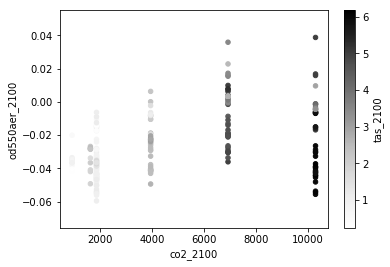

In [5]:
ax = df.plot.scatter(x='co2_2100', y='od550aer_2100', c='tas_2100')

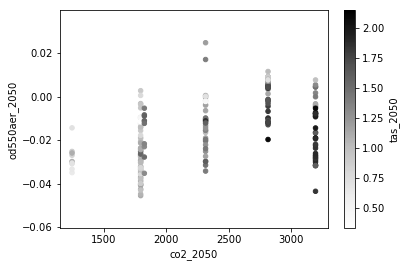

In [6]:
ax = df.plot.scatter(x='co2_2050', y='od550aer_2050', c='tas_2050')

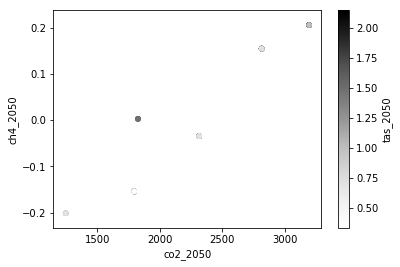

In [7]:
ax = df.plot.scatter(x='co2_2050', y='ch4_2050', c='tas_2050')

Todo:
 - ~Rescale the temperature to be an anomoly to that models historical temperature~
 - ~These CO2 are fine but if I bring in the emissions I'll need to take the cumulative emissions (since PI)~
 - ~Actually, looking at Millar et al. 2017, we can just use cumulative emissions and temperature change since PD - it's the same line~
 - Consider bringing in the DAMIP runs (would have to work out the exact setupts though)
 - Maybe change to RF?
 - What to do with different ensemble members? Just take mean? Take first one?
 - Which year to choose? Would be nice to look at a couple of years
 - Could consider bringigng in the PDRMIP data too

In [23]:
# Collapse ensemble members
df = df.groupby(['model', 'scenario']).mean()
df

tas_2050  od550aer_2050  tas_2100  od550aer_2100  \
model           scenario                                                     
ACCESS-CM2      ssp126    1.000582      -0.025191  1.407198      -0.038552   
                ssp245    1.187015      -0.012222  2.489487      -0.027589   
                ssp370    1.103402       0.006077  3.791109       0.001188   
                ssp585    1.478602      -0.008842  5.016310      -0.016805   
ACCESS-ESM1-5   ssp126    0.819904      -0.013947  0.967981      -0.015895   
                ssp245    1.078853      -0.004727  2.052867      -0.009796   
                ssp370    1.047218       0.003862  3.422980       0.000495   
                ssp585    1.412020      -0.002210  4.096812      -0.001356   
CESM2           ssp126    0.974787      -0.003323  1.134402      -0.010735   
                ssp245    1.119462       0.000371  2.303586       0.000121   
                ssp370    1.154434       0.007554  3.501974       0.016237   
                ssp585    1.453782       0.002178  4.980513       0.016340   
CESM2-WACCM     ssp126    0.770853       0.000561  1.053462      -0.006278   
                ssp245    1.118329       0.000520  2.252389       0.006330   
                ssp370    1.022903       0.011563  3.526784       0.035894   
                ssp585    1.311378       0.005453  5.010599       0.038768   
CanESM5         ssp119    0.641977      -0.030857  0.333723      -0.036624   
                ssp126    0.989167      -0.029769  0.953098      -0.041451   
                ssp245    1.318495      -0.016138  2.454336      -0.033573   
                ssp370    1.724648      -0.004288  4.744037      -0.021374   
                ssp434    1.304015      -0.023741  1.863815      -0.040477   
                ssp585    1.877571      -0.025367  5.984793      -0.040852   
HadGEM3-GC31-LL ssp126    0.768553      -0.026508  1.314000      -0.037692   
                ssp245    1.262740      -0.014397  2.651430      -0.024341   
                ssp585    1.606117      -0.007902  5.547793      -0.015396   
MIROC-ES2L      ssp119    0.703733      -0.014334  0.557255      -0.020002   
                ssp126    0.785037      -0.017767  0.572429      -0.028761   
                ssp245    0.789146      -0.010066  1.589075      -0.019236   
                ssp370    1.131194       0.001314  2.623115       0.006749   
                ssp585    1.117971      -0.003265  3.748485      -0.003236   
MPI-ESM1-2-HR   ssp126    0.370221      -0.009666  0.351424      -0.014088   
                ssp245    0.735819      -0.001871  1.352010      -0.008150   
                ssp370    0.819827       0.008950  2.616101       0.003430   
                ssp585    0.946618       0.004603  3.153594      -0.004407   
MPI-ESM1-2-LR   ssp126    0.518146      -0.009654  0.358184      -0.014067   
                ssp370    0.877299       0.008940  2.610222       0.003437   
                ssp585    1.029724       0.004613  3.278956      -0.004377   
NorESM2-LM      ssp126    0.331449      -0.011588  0.376486      -0.017219   
                ssp245    0.533042      -0.001380  1.295670      -0.005419   
                ssp370    0.704050       0.007691  2.552758       0.022834   
                ssp585    0.983765       0.007667  2.957163       0.009652   
UKESM1-0-LL     ssp119    0.918189      -0.027682  0.970074      -0.035182   
                ssp126    1.284645      -0.024166  1.563342      -0.036149   
                ssp245    1.604553      -0.010934  3.040434      -0.022142   
                ssp370    1.749074       0.004618  5.046036       0.007180   
                ssp434    1.511831      -0.009184  2.371976      -0.027848   
                ssp585    2.028151      -0.007564  6.038747      -0.006429   

                             co2_2050      co2_2100  so2_2050  so2_2100  \
model           scenario                                                  
ACCESS-CM2      ssp126    1795.710867   1848.864201 -

In [24]:
msk = np.random.rand(len(df)) < 0.8
train, test = df[msk], df[~msk]
train = df
print(train.describe())
print(test.describe())

        tas_2050  od550aer_2050   tas_2100  od550aer_2100     co2_2050  \
count  47.000000      47.000000  47.000000      47.000000    47.000000   
mean    1.085538      -0.006851   2.593171      -0.010997  2415.708964   
std     0.381735       0.011775   1.607547       0.019747   613.880074   
min     0.331449      -0.030857   0.333723      -0.041451  1247.788346   
25%     0.804487      -0.014140   1.304835      -0.025965  1795.710867   
50%     1.047218      -0.004727   2.489487      -0.010735  2314.385253   
75%     1.307697       0.003020   3.514379       0.000842  2813.146604   
max     2.028151       0.011563   6.038747       0.038768  3192.373467   

           co2_2100   so2_2050   so2_2100   ch4_2050   ch4_2100  
count     47.000000  47.000000  47.000000  47.000000  47.000000  
mean    5273.481207  -0.035145  -0.058602   0.024789   0.008781  
std     3407.071143   0.025320   0.022373   0.152382   0.228622  
min      905.867767  -0.069425  -0.082066  -0.201275  -0.257405  
25%

In [25]:
x_cols = ['co2_2050', 'od550aer_2050', 'ch4_2050']
y_cols = ['tas_2050']

def get_model(x_cols):
    # meanf = gpflow.mean_functions.Linear(active_dims=[0,1,2])
    k = gpflow.kernels.Linear(variance=np.ones(len(x_cols))) + gpflow.kernels.Exponential(lengthscales=np.ones(len(x_cols)))
    m = gpflow.models.GPR(data=(train[x_cols].values, train[y_cols].values), kernel=k,)
    gpflow.utilities.print_summary(m)
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))
    # gpflow.utilities.print_summary(m)
    return m

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value              │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ (1,)    │ float64 │ [1.]               │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.9999999999999999 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────┤
│ GPR.kernel.kernels[1].lengthscales │ Parameter │ Soft

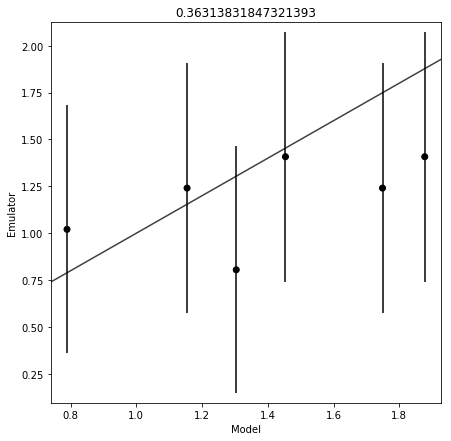

In [26]:
m = get_model(['co2_2050'], )
Y_Pred, Y_var = m.predict_y(test[['co2_2050']].values)
                            
validation_plot(test[y_cols].values, Y_Pred, Y_var)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value              │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ (2,)    │ float64 │ [1. 1.]            │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.9999999999999999 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────┤
│ GPR.kernel.kernels[1].lengthscales │ Parameter │ Soft

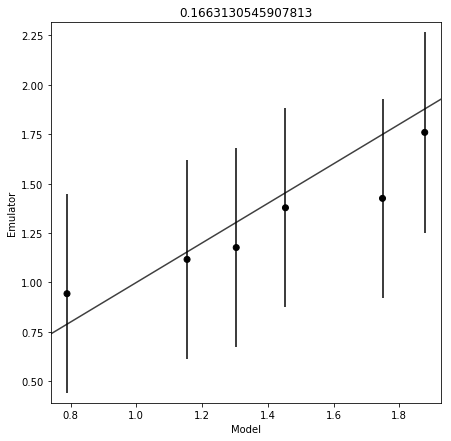

In [27]:
m = get_model(['co2_2050', 'od550aer_2050'], )
Y_Pred, Y_var = m.predict_y(test[['co2_2050', 'od550aer_2050']].values)
                            
validation_plot(test[y_cols].values, Y_Pred, Y_var)

In [28]:
xx, yy = np.meshgrid(np.linspace(0, 4000, 25), np.linspace(-.05, 0.05, 20))
X_new = np.stack([xx.flat, yy.flat], axis=1)
Y_new, Y_new_sigma = m.predict_y(X_new)

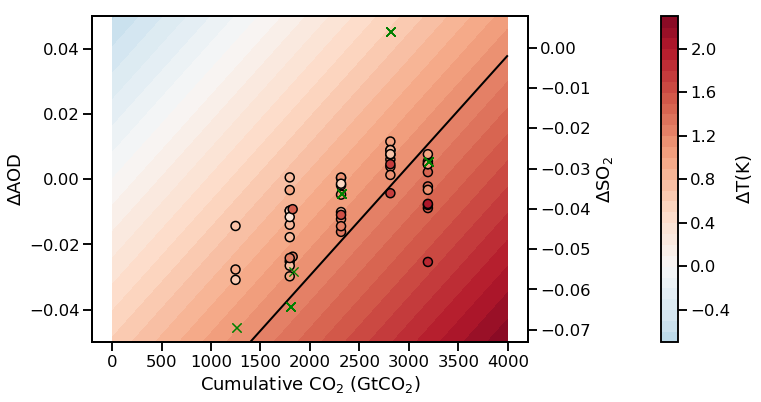

In [29]:
import matplotlib
import seaborn as sns


with sns.plotting_context("talk"):

    plt.figure(figsize=(12, 6))

    norm = matplotlib.colors.Normalize(vmin=-2.5,vmax=2.5)
    p = plt.contourf(xx, yy, Y_new.numpy().reshape(xx.shape), norm=norm, levels =30, cmap='RdBu_r')
    
    cl = plt.contour(xx, yy, Y_new.numpy().reshape(xx.shape), levels = [1.2],
                 colors=('k',),linestyles=('-',),linewidths=(2,))
#     plt.clabel(cl)#, manual=[(20,20), (0.8, 0.1)])
#     plt.scatter(test.co2_2050, test.od550aer_2050, c=test.tas_2050, norm=norm, edgecolors='k')
    plt.scatter(train.co2_2050, train.od550aer_2050, c=train.tas_2050, norm=norm, edgecolors='k', cmap='RdBu_r')
    ax1 = plt.gca()
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.plot(train.co2_2050, train.so2_2050, 'gx')
    
#     c = plt.contour(xx[0, :, :], zz[0, :, :], Y_new_sigma.numpy().reshape(xx.shape)[0, :, :])

    plt.setp(ax1, xlabel='Cumulative CO$_2$ (GtCO$_2$)', ylabel='$\Delta$AOD')
    plt.setp(ax2, ylabel='$\Delta$SO$_2$')

    plt.colorbar(p, label='$\Delta$T(K)', pad=0.2)
    # Cumulative CO2, delta T and delta AOD all relative to a 2015-2020 average. Each point represents a single model integration for different scenarios in the CMIP6 archive. 
#     plt.colorbar(c)

In [30]:
scn_mean = train.groupby(['scenario']).mean()
print(scn_mean)

          tas_2050  od550aer_2050  tas_2100  od550aer_2100     co2_2050  \
scenario                                                                  
ssp119    0.754633      -0.024291  0.620351      -0.030603  1247.788346   
ssp126    0.783031      -0.015547  0.913819      -0.023717  1795.710867   
ssp245    1.074745      -0.007084  2.148128      -0.014379  2314.385253   
ssp370    1.133405       0.005628  3.443512       0.007607  2813.146604   
ssp434    1.407923      -0.016463  2.117896      -0.034162  1825.355018   
ssp585    1.385973      -0.002785  4.528524      -0.002555  3192.373467   

              co2_2100  so2_2050  so2_2100  ch4_2050  ch4_2100  
scenario                                                        
ssp119      905.867767 -0.069425 -0.080790 -0.201275 -0.257405  
ssp126     1848.864201 -0.064020 -0.082066 -0.153999 -0.241390  
ssp245     3932.717046 -0.035997 -0.059775 -0.034673 -0.092845  
ssp370     6912.965613  0.004142 -0.020179  0.154481  0.368859  
ssp434   

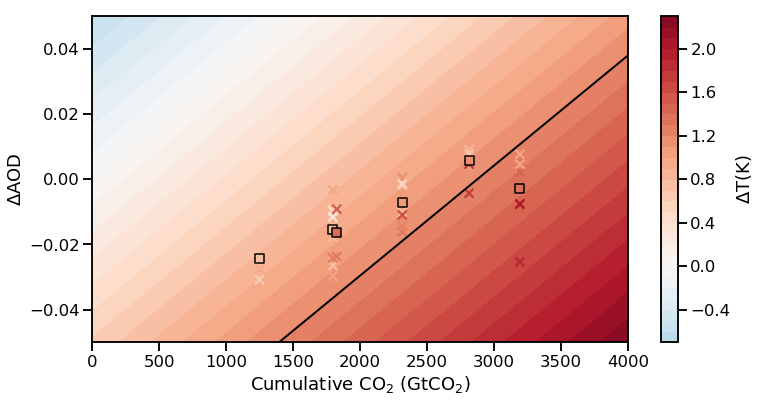

In [31]:
import matplotlib
import seaborn as sns


with sns.plotting_context("talk"):

    plt.figure(figsize=(12, 6))

    norm = matplotlib.colors.Normalize(vmin=-2.5,vmax=2.5)
    p = plt.contourf(xx, yy, Y_new.numpy().reshape(xx.shape), norm=norm, levels=30, cmap='RdBu_r')
    
    cl = plt.contour(xx, yy, Y_new.numpy().reshape(xx.shape), levels = [1.2],
                 colors=('k',),linestyles=('-',),linewidths=(2,))
    
#     plt.clabel(cl)#, manual=[(20,20), (0.8, 0.1)])
#     plt.scatter(test.co2_2050, test.od550aer_2050, c=test.tas_2050, norm=norm, edgecolors='k')
    plt.scatter(train.co2_2050, train.od550aer_2050, c=train.tas_2050, norm=norm, edgecolors='k', cmap='RdBu_r', marker='x')
    plt.scatter(scn_mean.co2_2050, scn_mean.od550aer_2050, c=scn_mean.tas_2050, norm=norm, edgecolors='k', cmap='RdBu_r', marker='s')
    

    plt.setp(plt.gca(), xlabel='Cumulative CO$_2$ (GtCO$_2$)', ylabel='$\Delta$AOD')

    plt.colorbar(p, label='$\Delta$T(K)')
    
    # Cumulative CO2, delta T and delta AOD all relative to a 2015-2020 average. Each point represents a single model integration for different scenarios in the CMIP6 archive. 
    plt.savefig('CMIP6_emulator_paper_v1.1.png', transparent=True)


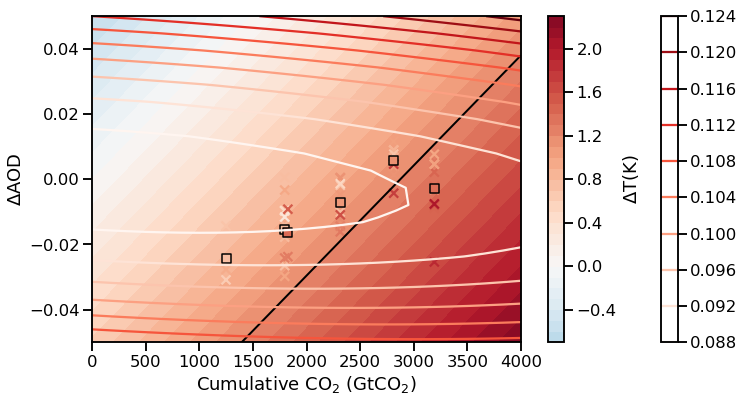

In [32]:
import matplotlib
import seaborn as sns


with sns.plotting_context("talk"):

    plt.figure(figsize=(12, 6))

    norm = matplotlib.colors.Normalize(vmin=-2.5,vmax=2.5)
    p = plt.contourf(xx, yy, Y_new.numpy().reshape(xx.shape), norm=norm, levels=30, cmap='RdBu_r')
    
    cl = plt.contour(xx, yy, Y_new.numpy().reshape(xx.shape), levels = [1.2],
                 colors=('k',),linestyles=('-',),linewidths=(2,))
    
#     plt.clabel(cl)#, manual=[(20,20), (0.8, 0.1)])
#     plt.scatter(test.co2_2050, test.od550aer_2050, c=test.tas_2050, norm=norm, edgecolors='k')
    plt.scatter(train.co2_2050, train.od550aer_2050, c=train.tas_2050, norm=norm, edgecolors='k', cmap='RdBu_r', marker='x')
    plt.scatter(scn_mean.co2_2050, scn_mean.od550aer_2050, c=scn_mean.tas_2050, norm=norm, edgecolors='k', cmap='RdBu_r', marker='s')
    
    c = plt.contour(xx, yy, Y_new_sigma.numpy().reshape(xx.shape), cmap='Reds', levels=10)

    plt.setp(plt.gca(), xlabel='Cumulative CO$_2$ (GtCO$_2$)', ylabel='$\Delta$AOD')

    plt.colorbar(c)
    plt.colorbar(p, label='$\Delta$T(K)')
    
    # Cumulative CO2, delta T and delta AOD all relative to a 2015-2020 average. Each point represents a single model integration for different scenarios in the CMIP6 archive. 
    plt.savefig('CMIP6_emulator_paper_v1.1.png', transparent=True)


# Including methane

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value      │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ (3,)    │ float64 │ [1. 1. 1.] │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.0        │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[1].lengthscales │ Parameter │ Softplus         │         │ True        │ (3,)    │ float64

<ipython-input-2-f357e89c4766>:27: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  connector, caplines, (vertical_lines,) = ax.errorbar(test_mean, pred_mean, fmt='none',


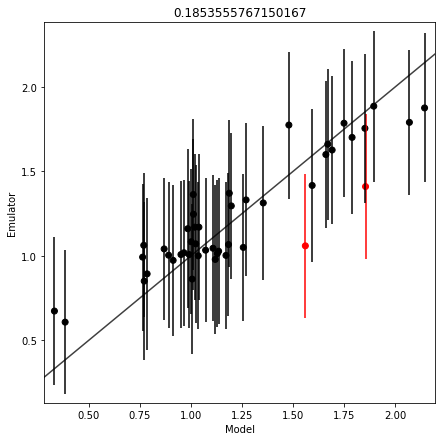

In [14]:
m = get_model(['co2_2050', 'ch4_2050', 'od550aer_2050'], )
Y_Pred, Y_var = m.predict_y(test[['co2_2050', 'ch4_2050', 'od550aer_2050']].values)
                            
validation_plot(test[y_cols].values, Y_Pred, Y_var)

In [15]:
X_new = np.stack([np.random.uniform(0, 10000, (500,)), np.zeros(500), np.random.uniform(-.05, 0.05, (500,))]).T
# X_new = np.stack([np.random.uniform(0, 10000, (500,)), np.zeros(500), np.random.uniform(-.5, 0.5, (500,))]).T

X_new.shape

(500, 3)

In [16]:
Y_new, _ = m.predict_y(X_new)

In [17]:
Y_new.shape

TensorShape([500, 1])

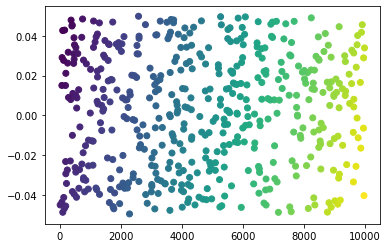

In [18]:
plt.scatter(X_new[:, 0], X_new[:, 2], c=Y_new[:, 0])

In [19]:
xx, yy, zz = np.meshgrid(np.linspace(1000, 3500, 20), np.zeros(20), np.linspace(-.06, 0.03, 20))

In [20]:
xx.shape

(20, 20, 20)

In [21]:
X_new = np.stack([xx.flat, yy.flat, zz.flat], axis=1)

In [22]:
X_new.shape

(8000, 3)

In [23]:
Y_new, Y_new_sigma = m.predict_y(X_new)

In [24]:
Y_new.shape

TensorShape([8000, 1])

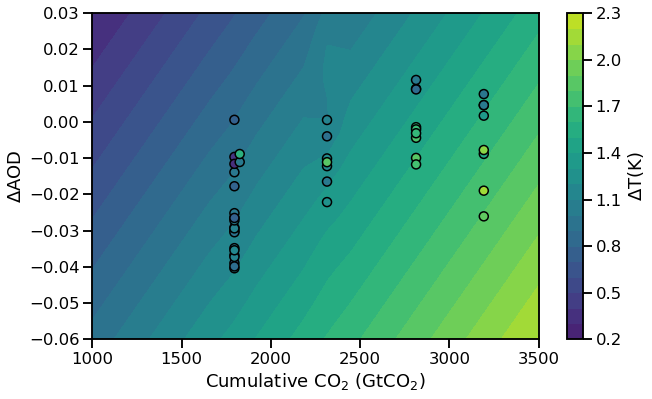

In [25]:
import matplotlib
import seaborn as sns


with sns.plotting_context("talk"):

    plt.figure(figsize=(10, 6))

    norm = matplotlib.colors.Normalize(vmin=0.,vmax=2.5)
    p = plt.contourf(xx[0, :, :], zz[0, :, :], Y_new.numpy().reshape(xx.shape)[0, :, :], norm=norm, levels =20)
    plt.scatter(test.co2_2050, test.od550aer_2050, c=test.tas_2050, norm=norm, edgecolors='k')

#     c = plt.contour(xx[0, :, :], zz[0, :, :], Y_new_sigma.numpy().reshape(xx.shape)[0, :, :])


    plt.setp(plt.gca(), xlabel='Cumulative CO$_2$ (GtCO$_2$)', ylabel='$\Delta$AOD')

    plt.colorbar(p, label='$\Delta$T(K)')
#     plt.colorbar(c)

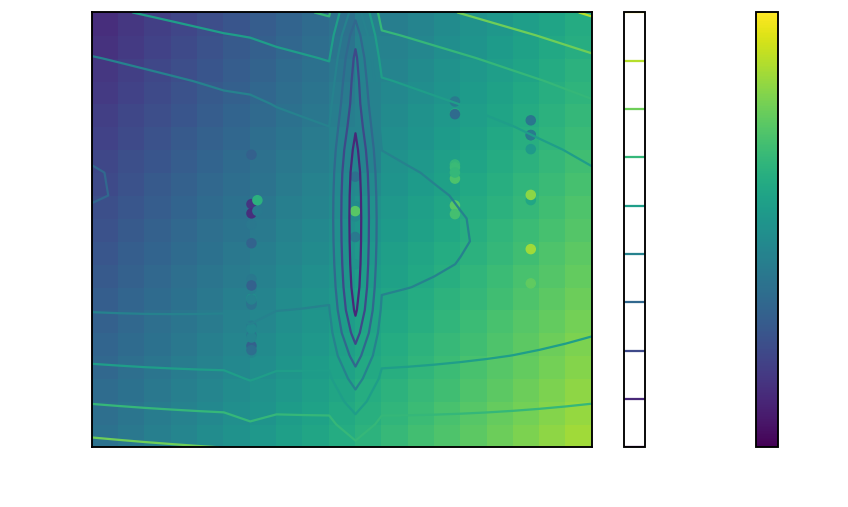

In [26]:
import seaborn as sns


with sns.plotting_context("talk"):
    COLOR = 'white'
    matplotlib.rcParams['text.color'] = 'black'  # Keep the legend black
    matplotlib.rcParams['axes.labelcolor'] = COLOR
    matplotlib.rcParams['xtick.color'] = COLOR
    matplotlib.rcParams['ytick.color'] = COLOR
    matplotlib.rcParams['font.size'] = 20

    plt.figure(figsize=(14, 8))

    norm = matplotlib.colors.Normalize(vmin=0.,vmax=2.5)
    p = plt.pcolormesh(xx[0, :, :], zz[0, :, :], Y_new.numpy().reshape(xx.shape)[0, :, :], norm=norm)
    plt.scatter(test.co2_2050, test.od550aer_2050, c=test.tas_2050, norm=norm, edgecolors=None)

    c = plt.contour(xx[0, :, :], zz[0, :, :], Y_new_sigma.numpy().reshape(xx.shape)[0, :, :])

    plt.setp(plt.gca(), xlabel='Cumulative CO$_2$ (GtCO$_2$)', ylabel='$\Delta$AOD')

    plt.colorbar(p, label='$\Delta$T(K)')
    plt.colorbar(c)
    
    plt.savefig('CMIP6_emulator_talk.png', transparent=True)

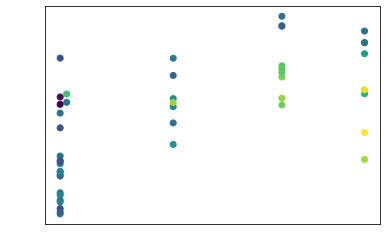

In [27]:
plt.scatter(test.co2_2050, test.od550aer_2050, c=test.tas_2050)